#遷移學習(categorical)計算confusion matrix

resnet50

### Import必要套件

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/My Drive/TFkeras/catdog.zip' /content

In [ ]:
!unzip /content/catdog.zip -d /content/

### cats_vs_dogs
載入cats_vs_dogs數據集

In [ ]:
generator = ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2,
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,  # randomly flip images
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
    )

In [ ]:
testgenerator = ImageDataGenerator(rescale = 1./255,
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
    )

In [ ]:
train_dir='/content/catdog/train/'

In [ ]:
test_dir='/content/catdog/test/'

In [ ]:
target_size = [128, 128]
batch_size = 64

In [ ]:
train_gen = generator.flow_from_directory(train_dir,
 target_size = target_size,
 batch_size = batch_size,
 shuffle=True,
 class_mode = 'categorical',                                        
 subset='training')

val_gen = generator.flow_from_directory(train_dir,
 target_size = target_size,
 batch_size = batch_size,
 shuffle=True,
 class_mode = 'categorical',                                        
 subset='validation')

test_gen = testgenerator.flow_from_directory(test_dir,
 target_size = target_size,                                          
 batch_size = 1,
 class_mode = 'categorical',                                        
)

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
print(train_gen.samples, val_gen.samples, test_gen.samples)

16000 4000 5000


In [ ]:
print(train_gen.class_indices)

{'cat': 0, 'dog': 1}


In [ ]:
# initializing label list and feeding in classes/indices
labels = [None]*len(train_gen.class_indices)

for item, indice in train_gen.class_indices.items():
    labels[indice] = item

In [ ]:
labels

['cat', 'dog']

### 訓練Model-1

設定回調函數：

In [ ]:
# 儲存最好的網路模型權重
model_mckp = keras.callbacks.ModelCheckpoint('/content/drive/My Drive/TFkeras/resnet50.h5', 
                                             monitor='val_categorical_accuracy', 
                                             save_best_only=True, 
                                             mode='max')
# 設定停止訓練的條件(當Accuracy超過5迭代沒有上升的話訓練會終止)
# model_esp = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=5)

創建ResNet50網路模型

In [ ]:
# 創建模型(不包含全連接層和預訓練權重)，最後一層卷積加上GlobalAveragePooling
base_model = tf.keras.applications.resnet.ResNet50(include_top=False, 
                                               weights='imagenet', 
                                               pooling='avg', 
                                               input_shape=target_size+[3])
# 將剛創建的InceptionV3模型接上兩層全連接層，並且最後一層使用Sigmoid輸出
model_1 = tf.keras.Sequential([
    base_model,
    layers.Dense(128, activation='relu'), 
    layers.Dense(2, activation='softmax')
])


透過model.summary查看網路模型資訊

In [ ]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_4 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 23,850,242
Trainable params: 23,797,122
Non-trainable params: 53,120
_________________________________________________________________


設定訓練使用的優化器、損失函數和指標函數

In [ ]:
adam = optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, amsgrad=False)
rlr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, verbose=1, min_delta=0.0001)

model_1.compile(optimizer=adam,
                loss='categorical_crossentropy', 
                metrics=['categorical_accuracy'])

訓練網路模型

In [ ]:
history = model_1.fit_generator(generator=train_gen,
                        steps_per_epoch = train_gen.samples//batch_size,
                        validation_data=val_gen,
                        validation_steps= val_gen.samples//batch_size,
                        epochs=30, 
                        callbacks=[rlr, model_mckp])

Epoch 1/30
250/250 [==============================] - 137s 546ms/step - loss: 0.3709 - categorical_accuracy: 0.8459 - val_loss: 1.1135 - val_categorical_accuracy: 0.4980
Epoch 2/30
250/250 [==============================] - 132s 527ms/step - loss: 0.2500 - categorical_accuracy: 0.8991 - val_loss: 0.8221 - val_categorical_accuracy: 0.4655
Epoch 3/30
250/250 [==============================] - 135s 539ms/step - loss: 0.2175 - categorical_accuracy: 0.9098 - val_loss: 0.8283 - val_categorical_accuracy: 0.5499
Epoch 4/30
250/250 [==============================] - 135s 540ms/step - loss: 0.2048 - categorical_accuracy: 0.9160 - val_loss: 0.3337 - val_categorical_accuracy: 0.8473
Epoch 5/30
250/250 [==============================] - 135s 541ms/step - loss: 0.1853 - categorical_accuracy: 0.9254 - val_loss: 0.3122 - val_categorical_accuracy: 0.8742
Epoch 6/30
250/250 [==============================] - 132s 529ms/step - loss: 0.1802 - categorical_accuracy: 0.9258 - val_loss: 0.4961 - val_categoric

#預測

In [ ]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend as K
import itertools

def get_conf_matrix(model, data_dir, size, image_size):
    predictions =[]
    true_y = []
    for x,y in testgenerator.flow_from_directory(data_dir, batch_size=1, target_size=image_size, shuffle=False):
        predprob = model.predict(x)
        # decoding one-hot
        prediction = np.argmax(predprob, axis=1)
        y = np.argmax(y, axis =1)
        
        predictions = np.concatenate((predictions, prediction))
        true_y = np.concatenate((true_y, y))
        if len(predictions) >=size:
            break
    matrix = confusion_matrix(true_y, predictions)

    return matrix

In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/TFkeras/resnet50.h5')
conf_matrix_resnet = get_conf_matrix(model, test_dir, test_gen.samples, target_size)
print(conf_matrix_resnet[:,:])
del model
K.clear_session()

Found 5000 images belonging to 2 classes.
[[2378  122]
 [  80 2420]]


Confusion matrix, without normalization
[[2378  122]
 [  80 2420]]


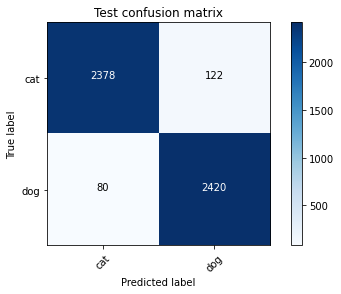

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(conf_matrix_resnet, labels, title = "Test confusion matrix")

In [ ]:
sum([conf_matrix_resnet[i, i] for i in range(2)])/test_gen.samples

0.9596